In [1]:
import torch
import random
import numpy as np
import torchvision.datasets
import matplotlib.pyplot as plt

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

100.1%

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


113.5%

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


100.4%

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


180.4%

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


In [5]:
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

In [7]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [8]:
X_train = X_train.float()
X_test = X_test.float()

In [9]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [10]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

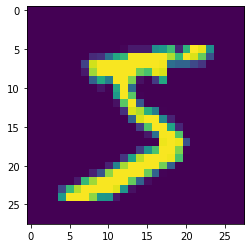

tensor(5)


In [11]:
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [12]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [16]:
X_train.size()

torch.Size([60000, 784])

In [17]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x
    
mnist_net = MNISTNet(100)

In [18]:
torch.cuda.is_available()

True

In [20]:
!nvidia-smi

Tue May 12 16:32:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 105...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   47C    P0    N/A /  N/A |    763MiB /  4042MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)
list(mnist_net.parameters())

[Parameter containing:
 tensor([[-0.0003,  0.0192, -0.0294,  ...,  0.0219,  0.0037,  0.0021],
         [-0.0198, -0.0150, -0.0104,  ..., -0.0203, -0.0060, -0.0299],
         [-0.0201,  0.0149, -0.0333,  ..., -0.0203,  0.0012,  0.0080],
         ...,
         [ 0.0221,  0.0258, -0.0088,  ..., -0.0141,  0.0051, -0.0318],
         [-0.0217, -0.0136,  0.0185,  ..., -0.0012, -0.0012, -0.0017],
         [ 0.0142,  0.0089, -0.0053,  ...,  0.0311, -0.0181,  0.0020]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-3.5402e-02,  1.8178e-02, -2.1709e-02, -1.1839e-02,  4.8722e-03,
         -1.0492e-02, -1.9008e-02,  2.6994e-02, -3.4899e-02,  1.0381e-02,
         -3.5228e-02, -5.6381e-03, -2.0134e-02, -3.0264e-02, -1.3289e-02,
          2.5346e-02, -1.0797e-02,  2.1568e-03,  4.3630e-03, -2.1916e-02,
          2.2670e-02, -1.5766e-02,  3.4906e-02, -2.3063e-02, -6.8216e-03,
          2.7051e-02, -1.3991e-02,  9.7218e-03, -9.9075e-04,  1.6625e-03,
          2.3455e-02, -

In [25]:
X_test = X_test.to(device)
y_test = y_test.to(device)

In [26]:
test_accuracy_history = []
test_loss_history = []

In [27]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

batch_size = 100

for epoch in range(100):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test))
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy)
    print(accuracy)

tensor(0.9067, device='cuda:0')
tensor(0.9161, device='cuda:0')
tensor(0.9184, device='cuda:0')
tensor(0.9171, device='cuda:0')
tensor(0.9237, device='cuda:0')
tensor(0.9182, device='cuda:0')
tensor(0.9165, device='cuda:0')
tensor(0.9309, device='cuda:0')
tensor(0.9270, device='cuda:0')
tensor(0.9285, device='cuda:0')
tensor(0.9334, device='cuda:0')
tensor(0.9312, device='cuda:0')
tensor(0.9308, device='cuda:0')
tensor(0.9362, device='cuda:0')
tensor(0.9364, device='cuda:0')
tensor(0.9358, device='cuda:0')
tensor(0.9389, device='cuda:0')
tensor(0.9362, device='cuda:0')
tensor(0.9303, device='cuda:0')
tensor(0.9413, device='cuda:0')
tensor(0.9422, device='cuda:0')
tensor(0.9463, device='cuda:0')
tensor(0.9407, device='cuda:0')
tensor(0.9400, device='cuda:0')
tensor(0.9408, device='cuda:0')
tensor(0.9353, device='cuda:0')
tensor(0.9393, device='cuda:0')
tensor(0.9456, device='cuda:0')
tensor(0.9410, device='cuda:0')
tensor(0.9320, device='cuda:0')
tensor(0.9416, device='cuda:0')
tensor(0

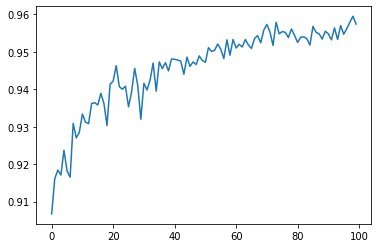

In [29]:
plt.plot(test_accuracy_history);

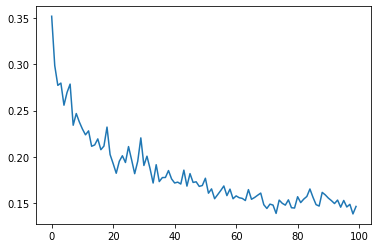

In [30]:
plt.plot(test_loss_history);

In [37]:
import torch

# Сперва создадим тензор x:
x = torch.tensor([[10., 20.]])

# Оригинальный полносвязный слой с 2-мя входами и 3-мя нейронами (выходами):
fc = torch.nn.Linear(2, 3)

# Веса fc-слоя хранятся в fc.weight, а bias'ы соответственно в fc.bias
# fc.weight и fc.bias по умолчанию инициализируются случайными числами

# Давайте проставим свои значения в веса и bias'ы:
w = torch.tensor([[11., 12.], [21., 22.], [31., 32]])
fc.weight.data = w

b = torch.tensor([[31., 32., 33.]])
fc.bias.data = b

# Получим выход fc-слоя:
fc_out = fc(x)

# Попробуем теперь получить аналогичные выходы с помощью матричного перемножения:
fc_out_alternative =  x.mm(w.T) + b # x * w^T + b

# Проверка осуществляется автоматически вызовом функции
print(fc_out == fc_out_alternative)
# (раскомментируйте, если решаете задачу локально)

tensor([[True, True, True]])


In [41]:
import torch

# Сперва создадим тензор x:
x = torch.tensor([[10., 20.]])

# Оригинальный полносвязный слой с 2-мя входами и 3-мя нейронами (выходами):
fc = torch.nn.Linear(2, 3)

# Веса fc-слоя хранятся в fc.weight, а bias'ы соответственно в fc.bias
# fc.weight и fc.bias по умолчанию инициализируются случайными числами

# Давайте проставим свои значения в веса и bias'ы:
w = torch.tensor([[11., 12.], [21., 22.], [31., 32]])
fc.weight.data = w

b = torch.tensor([[31., 32., 33.]])
fc.bias.data = b

# Получим выход fc-слоя:
fc_out = fc(x)
# Просуммируем выход fc-слоя, чтобы получить скаляр:
fc_out_summed = fc_out.sum()

# Посчитаем градиенты формулы fc_out_summed:
fc_out_summed.backward()
weight_grad = fc.weight.grad
bias_grad = fc.bias.grad

# Ok, теперь воспроизведем вычисления выше но без fc-слоя:
# Проставим, что у "w" и "b" нужно вычислять градиенты (для fc-слоя это произошло автоматически):
w.requires_grad_(True)
b.requires_grad_(True)

# Получим выход нашей формулы:
our_formula = (x.mm(w.T) + b).sum() # SUM{x * w^T + b}

# Сделайте backward для нашей формулы:
our_formula.backward()

# Проверка осуществляется автоматически, вызовом функций:
print('fc_weight_grad:', weight_grad)
print('our_weight_grad:', w.grad)
print('fc_bias_grad:', bias_grad)
print('out_bias_grad:', b.grad)
# (раскомментируйте, если работаете над задачей локально)

fc_weight_grad: tensor([[10., 20.],
        [10., 20.],
        [10., 20.]])
our_weight_grad: tensor([[10., 20.],
        [10., 20.],
        [10., 20.]])
fc_bias_grad: tensor([[1., 1., 1.]])
out_bias_grad: tensor([[1., 1., 1.]])
